In [1]:
import sys,os
sys.path.append("..")

MONGO_URL="localhost:27017"
os.environ["MONGO_URL"] = MONGO_URL

MONGO_VENDORBOT_DATABASE = "vendorbot_db"
os.environ["MONGO_VENDORBOT_DATABASE"] = MONGO_VENDORBOT_DATABASE

MOLECULES_DATABASE = "molecules_db"
os.environ["MOLECULES_DATABASE"] = MOLECULES_DATABASE

MONGO_BOT_USERNAME="bot"
os.environ["MONGO_BOT_USERNAME"] = MONGO_BOT_USERNAME

MONGO_BOT_PASSWORD="botpsswd"
os.environ["MONGO_BOT_PASSWORD"] = MONGO_BOT_PASSWORD

from modules.db.dbconfig import db_client
from modules.db.users import UsersCollection
from modules.db.unique_molecules import UniqueMolecules

# collections of data to work with
users_collection = UsersCollection(db_client, MONGO_VENDORBOT_DATABASE)
unique_molecules_collection = UniqueMolecules(db_client, MOLECULES_DATABASE)

print(db_client)
db_client.list_database_names()

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True, authsource='admin', connecttimeoutms=5)


['admin',
 'blacklist_rdkit_db',
 'config',
 'local',
 'molecules_db',
 'test_db',
 'vendorbot_db']

In [2]:

user_id = 122267418
query = {"user_id": user_id}
users_collection.collection.count_documents({"user_id": user_id}) 

1

In [10]:
index = "BKMMTJMQCTUHRP-VKHMYHEASA-N"
query = {'index': moldoc['index']}
unique_molecules_collection.collection.count_documents({"index": index}) 

NameError: name 'moldoc' is not defined

In [4]:
from rdkit import Chem
##########################
#FIXING CHARGED MOLECULES#
##########################
def neutralize_atoms(mol):
    '''
    atom neutralizer
    '''
    pattern = Chem.MolFromSmarts("[+1!h0!$([*]~[-1,-2,-3,-4]),-1!$([*]~[+1,+2,+3,+4])]")
    at_matches = mol.GetSubstructMatches(pattern)
    at_matches_list = [y[0] for y in at_matches]
    if len(at_matches_list) > 0:
        for at_idx in at_matches_list:
            atom = mol.GetAtomWithIdx(at_idx)
            chg = atom.GetFormalCharge()
            hcount = atom.GetTotalNumHs()
            atom.SetFormalCharge(0)
            atom.SetNumExplicitHs(hcount - chg)
            atom.UpdatePropertyCache()
    return mol

from rdkit.Chem.rdmolops import GetFormalCharge
def charge_fixer(SMILES):
    '''
    Neutralize molecules atom by atom
    '''
    # Create RDKit molecular objects
    mol = Chem.MolFromSmiles(smiles)
    if GetFormalCharge(mol) != 0:
        neutralize_atoms(mol)
    return Chem.MolToSmiles(mol)

In [5]:
# SMILES
smiles = 'CC[C@H]([NH3+])CO'

In [3]:
from rdkit import Chem
from mongordkit.Database import write
from mongordkit.Search import similarity, substructure
from mongordkit.Database import registration

In [5]:
SMILES = 'C[C@H](N)CO'
reagent_internal_id = 'a05785ae720b414ca41526baf22bc026'
unique_molecules_collection.reagent_registration(SMILES, reagent_internal_id)

populating mongodb collection with compounds from list...
0 molecules successfully imported
1 duplicates skipped
0


'BKMMTJMQCTUHRP-VKHMYHEASA-N'

In [12]:
SMILES = 'C[C@H](N)CO'
reagent_internal_id = 'a05785ae720b414ca41526baf22bc026'
# user_id = 122267418
# query = {"user_id": user_id}

def reagent_registration(SMILES, reagent_internal_id):

    molfile = Chem.MolFromSmiles(SMILES)
    scheme = registration.MolDocScheme()
    scheme.add_value_field('reagent_internal_id_list', [reagent_internal_id])
    moldoc = scheme.generate_mol_doc(molfile)

    result = write.WriteFromMolList(unique_molecules_collection.collection, [molfile], scheme=scheme) 
    print (result)
    # print(query)
    if result == 0:

        reagent_internal_id_list = unique_molecules_collection.get_molecule(moldoc['index'])["value_data"]['reagent_internal_id_list']
        
        if reagent_internal_id not in reagent_internal_id_list:
            reagent_internal_id_list.append(reagent_internal_id)

            scheme.add_value_field('reagent_internal_id_list', reagent_internal_id_list)

            # moldoc = scheme.generate_mol_doc(molfile)
            unique_molecules_collection.update_molecule(moldoc['index'], moldoc)


    inchikey_standard = moldoc['index']

    return inchikey_standard

reagent_registration(SMILES, reagent_internal_id)

populating mongodb collection with compounds from list...
0 molecules successfully imported
1 duplicates skipped
0


'BKMMTJMQCTUHRP-VKHMYHEASA-N'

In [6]:
reagent_internal_id = "f0a117bfdf8046179dba08fdbc0624f4"
users_collection.get_user_reagent_by_internal_id(reagent_internal_id)


In [9]:
molfile = Chem.MolFromSmiles(SMILES)
scheme = registration.MolDocScheme()
scheme.add_value_field('reagent_internal_id_list', [reagent_internal_id])
moldoc = scheme.generate_mol_doc(molfile)
print(moldoc)
unique_molecules_collection.add_molecule(moldoc)
result = write.WriteFromMolList(unique_molecules_collection, [molfile], scheme=scheme) 

{'rdmol': Binary(b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x05\x00\x00\x00\x04\x00\x00\x00\x80\x01\x06\x00`\x00\x00\x00\x01\x03\x06 4\x00\x00\x00\x02\x01\x04\x07\x00`\x00\x00\x00\x01\x02\x06\x00`\x00\x00\x00\x02\x02\x08\x00`\x00\x00\x00\x01\x01\x0b\x00\x01\x00\x01\x02\x00\x01\x03\x00\x03\x04\x00\x14\x00\x17\x04\x00\x00\x00\x00\x00\x00\x00\x16', 0), 'index': 'BKMMTJMQCTUHRP-VKHMYHEASA-N', 'smiles': 'C[C@H](N)CO', 'scheme': 'default', 'hashes': {'CanonicalSmiles': 'C[C@H](N)CO', 'inchikey_standard': 'BKMMTJMQCTUHRP-VKHMYHEASA-N'}, 'fingerprints': {}, 'value_data': {'reagent_internal_id_list': ['a05785ae720b414ca41526baf22bc026']}}
populating mongodb collection with compounds from list...


AttributeError: 'UniqueMolecules' object has no attribute 'count_documents'

In [ ]:
print(unique_molecules_collection)

In [7]:
from rdkit import RDLogger, Chem
from mongordkit.Database import write
from mongordkit.Search import similarity, substructure

from rdkit.Chem import PandasTools, SanitizeMol


# Search.PrepareForSearch(rdkit_db, rdkit_db.molecules, rdkit_db.mfp_counts, rdkit_db.permutations)
substructure.AddPatternFingerprints(unique_molecules_collection.collection)
similarity.AddMorganFingerprints(unique_molecules_collection.collection, db_client[MOLECULES_DATABASE].mfp_counts)

# Generate 100 different permutations of length 2048 and save them in demo_db.permutations as separate documents.
similarity.AddRandPermutations(db_client[MOLECULES_DATABASE].permutations)

# Add locality-sensitive hash values to each documents in demo_db.molecules by splitting the 100 different permutations
# in demo_db.permutations into 25 different buckets.
similarity.AddLocalityHashes(unique_molecules_collection.collection, db_client[MOLECULES_DATABASE].permutations, 25)

# Create 25 different collections in db_demo each store a subset of hash values for molecules in demo_db.molecules.
similarity.AddHashCollections(db_client[MOLECULES_DATABASE], unique_molecules_collection.collection)

In [13]:
from operator import itemgetter
def similarity_search(database, smiles: str):
    """
    Ищем похожие реагенты умными функциями
    :param smiles:
    :return: отсортированный по похожести список реагентов
    """
    smiles = smiles.replace("|", "")  # вертикальная черта в SMILES - непонятно что несёт, и RDKIT ее не понимает, убираем ее
    mol = Chem.MolFromSmiles(smiles)

    if not mol:
        raise Exception("MolFromSmiles returned None")

    res = similarity.SimSearchAggregate(mol, database.unique_molecules_collection, database.mfp_counts, 0.1)

    if not res:
        return

    res = sorted(res, key=itemgetter(0), reverse=True)

    if res[0] is None:
        raise Exception(f"incorrect result: {str(res)}")

    return res

In [44]:
# def get_most_similar_reagent(SMILES):
    
#     best_similarity_result_id = similarity_search(db_client[MOLECULES_DATABASE], SMILES)[0][1]
#     reagent_internal_id_list = unique_molecules_collection.get_molecule(best_similarity_result_id)["value_data"]['reagent_internal_id_list']
#     best_match_smiles = unique_molecules_collection.get_molecule(best_similarity_result_id)["smiles"]
#     return (reagent_internal_id_list, best_match_smiles)


REQUESTED_SMILES = 'CCN=C=NCCCN(C)C'
best_match_smiles = unique_molecules_collection.get_most_similar_reagent(REQUESTED_SMILES)
# user_id = "122267418"

# def batch_reagent_registration(user_id: str):
#     reagent_list = users_collection.get_reagents(user_id)

#     for reagent in reagent_list:
#         SMILES = reagent['SMILES']
#         reagent_internal_id = reagent['reagent_internal_id']
#         reagent_registration(SMILES, reagent_internal_id)
best_match_smiles

(['65e4b5a5b692404097571f770d242831'],
 'CCCCCCCCCCCCCCCCCCS',
 0.16666666666666666)

In [50]:
print(users_collection.get_user_reagent_by_internal_id('6864be1e85ef463abf6e17b38217bc63 '))

None


()


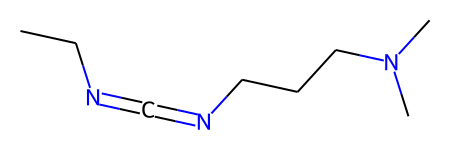

In [19]:
from rdkit import Chem
# from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
# IPythonConsole.ipython_useSVG=True  #< set this to False if you want PNGs instead of SVGs
# def mol_with_atom_index(mol):
#     for atom in mol.GetAtoms():
#         atom.SetAtomMapNum(atom.GetIdx())
#     return mol
mol_requested = Chem.MolFromSmiles(REQUESTED_SMILES)
# Default
mol_best_match = Chem.MolFromSmiles(best_match_smiles[0])
substructure = Chem.MolFromSmarts(REQUESTED_SMILES)

print(mol_best_match.GetSubstructMatches(substructure))
# Draw.MolsToGridImage((mol_requested, mol_best_match), subImgSize=(250,250))

# m = Chem.MolFromSmiles('c1cc(C(=O)O)c(OC(=O)C)cc1')
#
# m.GetSubstructMatches(substructure)
# m
# Chem.Draw.MolToFile(mol_best_match, "test.png")
mol_best_match


# from matplotlib.colors import ColorConverter 
# img = Draw.MolToImage(mol_best_match, highlightAtoms=[1,2], highlightColor=ColorConverter().to_rgb('red')) 
# img.save("molecule.png")

In [16]:
from modules.db.dbschema import UserReagents

In [17]:
user_reagents = UserReagents(users_collection.get_user(user_id))
user_reagents.export()


{'_id': '35ce656ef694434b9f0ab8c7abb5c23c', 'args': (None,)}

In [85]:
reagent_internal_id = 'd4bfb66beacb43cda65827b3ad458dc0'
if 'user_reagents' in user_reagents.export().keys():
    for reagent in user_reagents.user_reagents:
        print("check")
        if reagent_internal_id in reagent.values():
            reagent['test'] = "SUCCESS"
            print("reagent")
else:
    print('unsuc')

unsuc


In [88]:
user_reagents.export().keys()

dict_keys(['_id', 'args'])

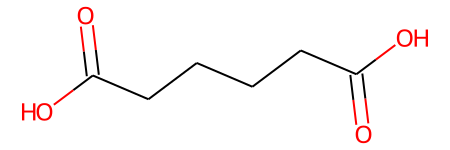

In [13]:
from rdkit import Chem
from rdkit.Chem import Draw
SMILES_FOR_TEST = "O=C(O)CCCCC(=O)O"
mol = Chem.MolFromSmiles(SMILES_FOR_TEST)
mol

In [24]:
for i in users_collection.get_users_by_smiles(SMILES_FOR_TEST)[0]["user_reagents"]:
    if i['SMILES'] == SMILES_FOR_TEST:
        print(i)

{'reagent_internal_id': '24c98620f6d24c9ebddef69432010df0', 'inchikey_standard': 'WNLRTRBMVRJNCN-UHFFFAOYSA-N', 'CAS': '124-04-9', 'SMILES': 'O=C(O)CCCCC(=O)O', 'sharing_status': 'shared', 'timestamp': '29.09.2022 15:20'}
{'reagent_internal_id': 'f3077cb9f4b1418fb67baa1044c3c927', 'inchikey_standard': 'WNLRTRBMVRJNCN-UHFFFAOYSA-N', 'CAS': '124-04-9', 'SMILES': 'O=C(O)CCCCC(=O)O', 'sharing_status': 'shared', 'timestamp': '29.09.2022 15:20'}


In [40]:
unique_molecules_collection.calculate_hashes()

In [38]:

mol = Chem.MolFromSmiles(best_match_smiles[0])
refmol = Chem.MolFromSmiles(REQUESTED_SMILES)

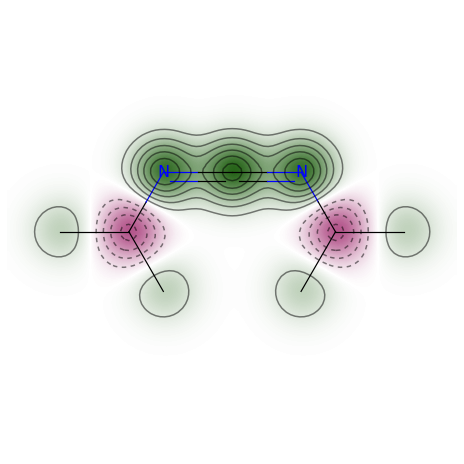

In [39]:

mol = Chem.MolFromSmiles(best_match_smiles[0])
refmol = Chem.MolFromSmiles(REQUESTED_SMILES)

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
fp = SimilarityMaps.GetAPFingerprint(mol, fpType='normal')
fp = SimilarityMaps.GetTTFingerprint(mol, fpType='normal')
fp = SimilarityMaps.GetMorganFingerprint(mol, fpType='bv')
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(refmol, mol, SimilarityMaps.GetMorganFingerprint)
fig.savefig("molpic.png", bbox_inches = "tight")



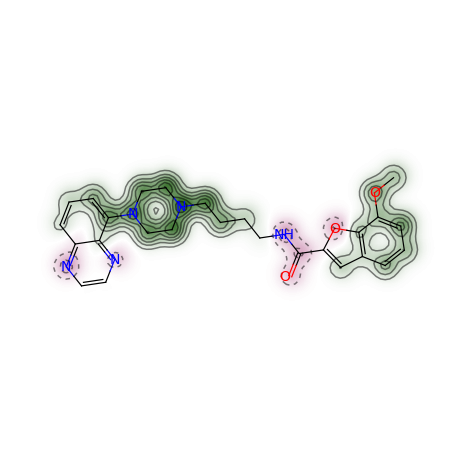

In [31]:
help(fig)

Help on Figure in module matplotlib.figure object:

class Figure(FigureBase)
 |  Figure(figsize=None, dpi=None, facecolor=None, edgecolor=None, linewidth=0.0, frameon=None, subplotpars=None, tight_layout=None, constrained_layout=None, *, layout=None, **kwargs)
 |  
 |  The top level container for all the plot elements.
 |  
 |  The Figure instance supports callbacks through a *callbacks* attribute
 |  which is a `.CallbackRegistry` instance.  The events you can connect to
 |  are 'dpi_changed', and the callback will be called with ``func(fig)`` where
 |  fig is the `Figure` instance.
 |  
 |  Attributes
 |  ----------
 |  patch
 |      The `.Rectangle` instance representing the figure background patch.
 |  
 |  suppressComposite
 |      For multiple images, the figure will make composite images
 |      depending on the renderer option_image_nocomposite function.  If
 |      *suppressComposite* is a boolean, this will override the renderer.
 |  
 |  Method resolution order:
 |      Figu

In [8]:
from modules.db.dbschema import get_contact

In [7]:
inchi = "KMKBZNSIJQWHJA-UHFFFAOYSA-N"
for i in users_collection.get_user_by_reagent_inchi_key(inchi):
    print(i['username'])

radical_subject
dunsicall_folly


In [10]:
[get_contact(i) for i in users_collection.get_user_by_reagent_inchi_key(inchi)]

['radical_subject', 'dunsicall_folly']